In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import random

from scipy import optimize
from theano import shared
from pymc3 import traceplot

C:\Users\bldr1\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
df = pd.read_csv('datosT3_.txt', header = None, sep = ',').transpose()
cols = ['x','y','label']
df.columns = cols
print(df[df.label == 1].shape,df[df.label == 0].shape)

(579, 3) (421, 3)


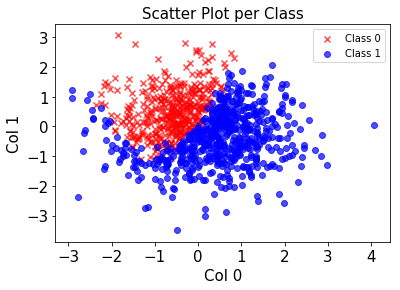

In [5]:
def class_scatter(x,y,label,w, LINE = False):
    %matplotlib inline
    plt.scatter(x[label == 0], y[label == 0], color = 'r', label = 'Class 0', alpha = 0.7, marker = 'x')
    plt.scatter(x[label == 1], y[label == 1], color = 'b', label = 'Class 1', alpha = 0.7, marker = 'o')
    plt.title('Scatter Plot per Class', fontsize = 15)
    plt.xlabel('Col 0', fontsize = 15)
    plt.ylabel('Col 1', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()
    #plt.savefig('ScatterClass')
    if LINE:
        line_x = np.linspace(-3, 3, 100)
        line_y = -w[1] / w[2] * line_x - w[0] / w[2]
        plt.plot(line_x,line_y, '--k', label = 'Frontera de decision')
        #for v1 in x1:
        #    for v2 in x2:
        #        line.append([v1,v2,w[0]+ w[1]*x1 + w[2]*x2])
        #print(line)
        #plt.scatter(x1[line < 0], x2[line < 0], color = 'r', label = 'Class 0', alpha = 0.7, marker = 'x')
        #plt.scatter(x1[line >= 1], x2[line >= 1], color = 'b', label = 'Class 1', alpha = 0.7, marker = 'o')
    plt.show()

class_scatter(df.x,df.y,df.label,[])

### Verosimilitud

[ 0.71665077  2.23176738 -2.1964844 ]


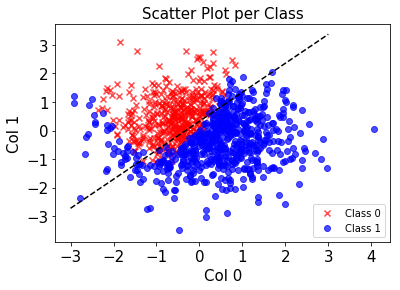

In [7]:
def funcion_logistica(x0,x1,w0,w1,w2):
    value = np.divide(1, 1 + np.exp(-w0 -w1*x0 -w2*x1) )
    return value

def nlog_ver(w):
    class_1 = np.log( funcion_logistica(df.x,df.y,*w) )
    class_1 = np.multiply(class_1, df.label)
    class_0 = np.log( 1 - funcion_logistica(df.x,df.y,*w) )
    class_0 = np.multiply(class_0, 1 - df.label)
    return -np.sum(class_0+class_1)

w_start = [0,0,0]
sol = optimize.minimize(nlog_ver,w_start,method = 'L-BFGS-B')
w_opt = sol.x
print(w_opt)
class_scatter(df.x,df.y,df.label,w_opt,True)

### MCMC

In [5]:
x_shared = shared(np.asarray(df.x))
y_shared = shared(np.asarray(df.y))

In [56]:
with pm.Model() as model:
    # Priors
    w0 = pm.Normal('w0', 4 , sd=100)
    w1 = pm.Normal('w1', 4 , sd=100)
    w2 = pm.Normal('w2', 4 , sd=100)
    
    #Probability C1
    C1_prob = pm.math.invlogit(w0 + w1*x_shared + w2*y_shared)
    
    #Posterior 
    #al parecer no cambia al multiplicar los priors o no
    posterior = pm.Binomial('posterior', n=1, p =C1_prob, observed = np.asarray(df.label))
    start = pm.find_MAP(model=model)
    step = pm.Metropolis()
    trace = pm.sample(5000, step=step, start=start)

logp = -inf, ||grad|| = 447.75: 100%|██████████| 4/4 [00:00<00:00, 363.28it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [w2]
>Metropolis: [w1]
>Metropolis: [w0]
The estimated number of effective samples is smaller than 200 for some parameters.


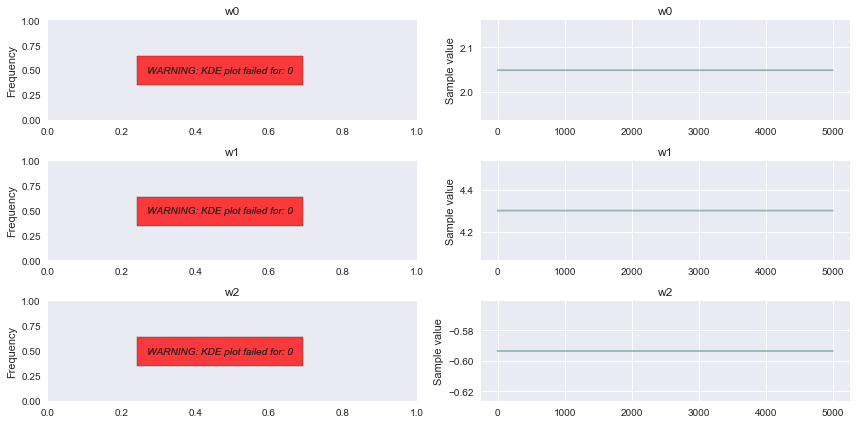

In [57]:
%matplotlib inline
traceplot(trace)
plt.show()

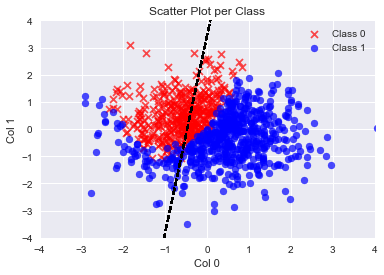

In [61]:
samples = random.sample(range(5000), 500)

plt.scatter(df.x[df.label == 0], df.y[df.label == 0], color = 'r', label = 'Class 0', alpha = 0.7, marker = 'x')
plt.scatter(df.x[df.label == 1], df.y[df.label == 1], color = 'b', label = 'Class 1', alpha = 0.7, marker = 'o')
plt.title('Scatter Plot per Class')
plt.xlabel('Col 0')
plt.ylabel('Col 1')
plt.legend()

for sample in np.asarray(trace)[samples]:
    w0 = sample.get('w0')
    w1 = sample.get('w1')
    w2 = sample.get('w2')
    line_x = np.linspace(-3, 3, 100)
    line_y = -w1 / w2 * line_x - w0 / w2
    plt.plot(line_x,line_y, '--k', label = 'Frontera de decision', alpha = 0.1)
    plt.xlim([-4,4])
    plt.ylim([-4,4])
plt.show()

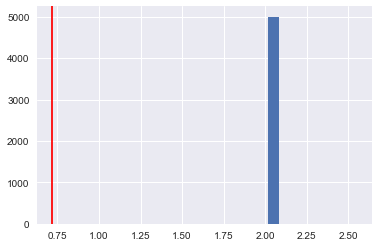

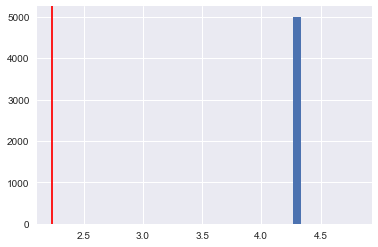

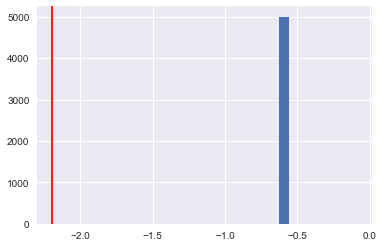

In [59]:
w0_list = []
w1_list = []
w2_list = []
for candidate in trace:
    w0_list.append(candidate.get('w0'))
    w1_list.append(candidate.get('w1'))
    w2_list.append(candidate.get('w2'))

plt.hist(w0_list, bins = 15)
plt.axvline(x=0.71665077,color='r')
plt.show()
plt.hist(w1_list,bins = 15)
plt.axvline(x=2.23176738,color='r')
plt.show()
plt.hist(w2_list,bins = 15)
plt.axvline(x=-2.1964844,color='r')
plt.show()